# Load data, prelim code 

In [1]:
# Run the flow cytometry script components from outside 


# prelims - setting working directory is important
{
    "metadata": {
        "jupyter" : {
        "source_hidden": True
        }
    }
}

# check current working directory
import os
os.chdir("..") # set path to the head directory of the project
os.getcwd()

# add project path to sys.path: enables loading local modules in other folders
import sys
module_path = os.getcwd()
# module_path = os.path.abspath(os.path.join('..'))

if module_path not in sys.path:
    sys.path.append(module_path)
sys.path # check that the last entry is the head project path

# Use for reloading modules when changes are made on the fly
import importlib # usage importlib.reload(module_name)

# Utilities
from sspipe import p, px # pipes usage: x | p(fn) | p(fn2, arg1, arg2 = px)

## Load Flowcal interfacing functions

In [2]:
# flowcal prerequisites
import FlowCal # flow cytometry processing
import numpy as np # for array manipulations - faster
import pandas as pd # for small data frames, csv outputs
import re # for regular expression : string matching

# enables automatic reloading of local modules when updated : For interactive use
%load_ext autoreload
%autoreload 2

# import local packages
from scripts_general_fns.g4_file_inputs import get_fcs_files
from scripts_general_fns.g14_gating_functions import gate_and_reduce_dataset

# import config : directory name and other definitions
from scripts_general_fns.g10_user_config import fcs_root_folder, fcs_experiment_folder,\
    make_processing_plots, beads_match_name,\
    channel_lookup_dict, use_channel_dimension
import scripts_general_fns.g10_user_config as config # in case you need more stuff

## Load fcs files

In [27]:
# Load fcs files within folder, not reading in .fcs data yet

# If this doesn't work, try changing the current working directory
# os.chdir(r'C:\Users\new\Box Sync\Stadler lab\Data\Flow cytometry (FACS)')

fcspaths, fcslist = get_fcs_files(fcs_root_folder + '/' + fcs_experiment_folder + '/')
# Loads them as lists in alphabetical order I assume?

# Load a single .fcs file

In [28]:
# Testing features on a small subset of data
# subset the relevant files to load
from scripts_general_fns.g3_python_utils_facs import subset_matching_regex
regex_to_subset = 'A02' # 'F05|D06' or '.*' for all

fcspaths_subset = subset_matching_regex(fcspaths, regex_to_subset)
fcslist_subset = subset_matching_regex(fcslist, regex_to_subset)

In [29]:
fcslist_subset

['A02 Well - A02 WLSM.fcs']

In [30]:
# load the subset of the .fcs files
fcs_data_subset = [FlowCal.io.FCSData(fcs_file) for fcs_file in fcspaths_subset]
    
# Load one file for testing
single_fcs = fcs_data_subset[0]

## Detect channel names
Automatically detects channel names used in the loaded single data from among `channel_lookup_dict` in `g10_user_config.py` file so that the code can run in a generalized manner

In [7]:
# get the relevant channels present in the data
relevant_channels = single_fcs.channels | p(subset_matching_regex, px, use_channel_dimension) 

# autodetect the channvels
fluorescence_channels, scatter_channels = tuple\
    (subset_matching_regex(relevant_channels, regx) for regx in channel_lookup_dict.values())

In [8]:
# check --
fluorescence_channels
# fcslist_subset

['mScarlet-I-A']

# Check a dataset

In [9]:
f'{single_fcs.__len__()} : number of events' # check that this is a non-empty file

'49334 : number of events'

# Process the beads

In [10]:
# Get beads within the folder  
beads_filepaths_list = [m for m in fcspaths if re.search(beads_match_name, m, re.IGNORECASE)]
if len(beads_filepaths_list) > 0 : # if beads are found
    beads_found = True
    beads_filepath = beads_filepaths_list[0] # take the first beads file

In [11]:
# RUN THIS INSTEAD OF THE ABOVE CELL FOR KNOWN BEADS FILE PATH ; IGNORE IF RUNNING ABOVE CELL
# ----------------------------------------------------------------------------------------------
# Get a custom beads file from a different folder and process it

# uncomment below line
# beads_filepath, beads_filename = get_fcs_files(fcs_root_folder + '/' + fcs_experiment_folder + 'S063c/S050_d-1/*/Beads/') 
# Tips: need to coerce the list to string before using "beads_filepath"

Reading beads from file : A12 Well - A12 WLSM.fcs


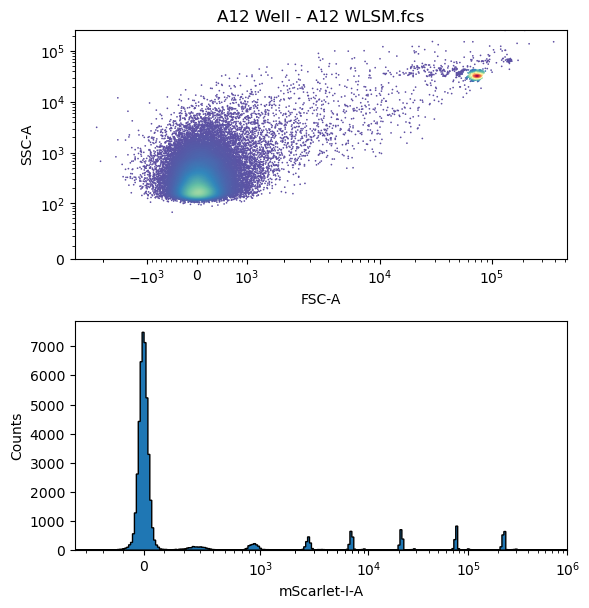

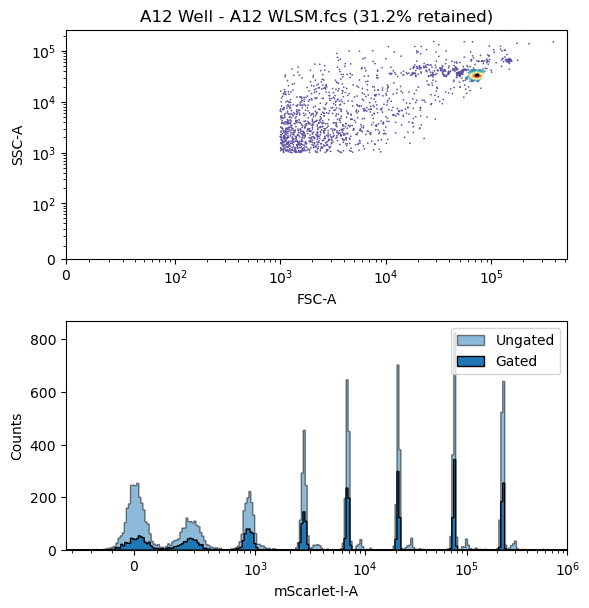

## Getting calibration data from beads

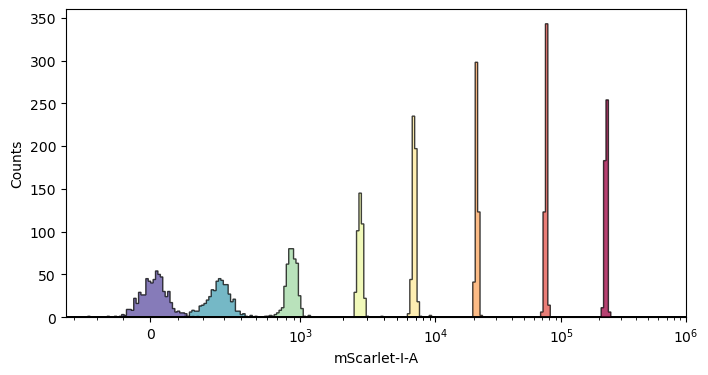

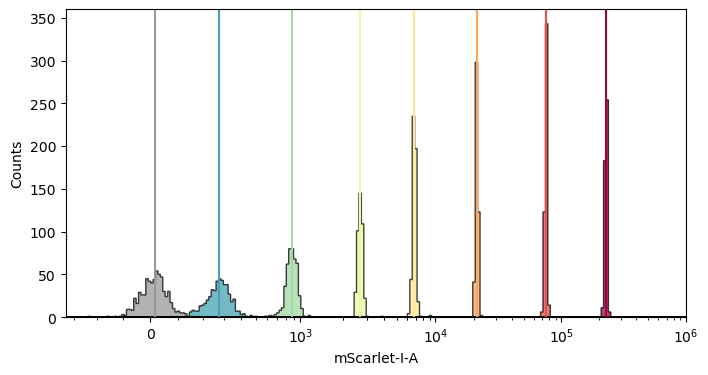

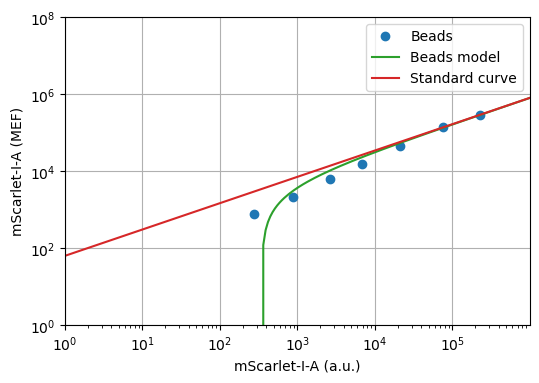

In [12]:
# Test beads processing function
from scripts_general_fns.g15_beads_functions import process_beads_file # get and process beads data

to_mef = process_beads_file(beads_filepath, scatter_channels, fluorescence_channels) # works!

# Bimodal troubleshooting : Plotting 1d histograms

---> Raw data


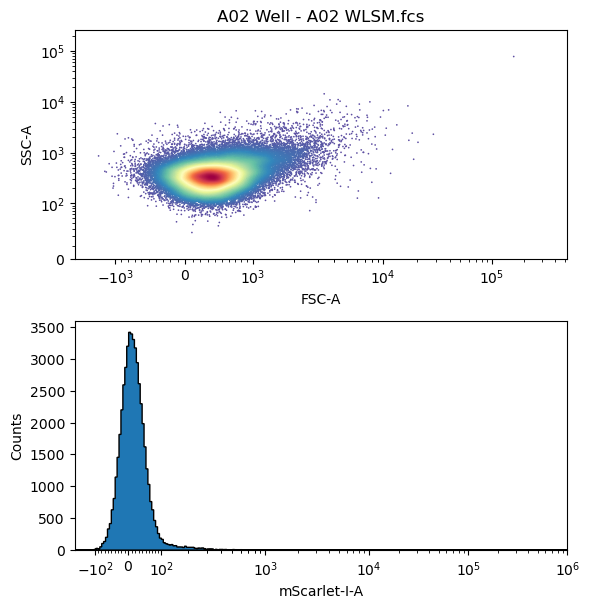

---> density gate


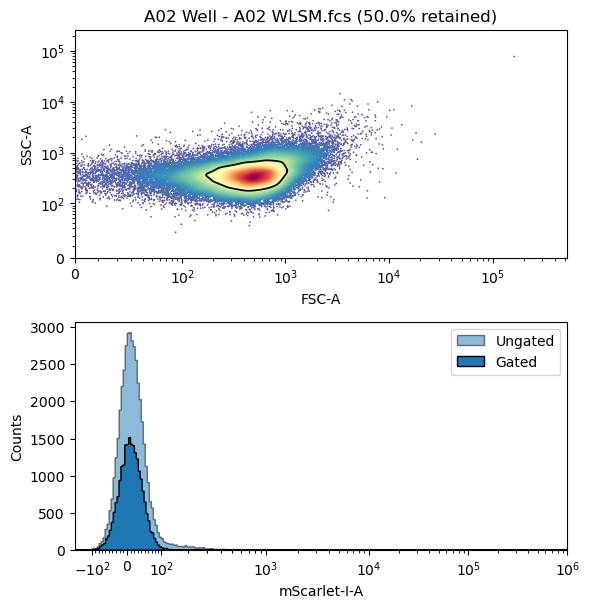

---> singlet gate


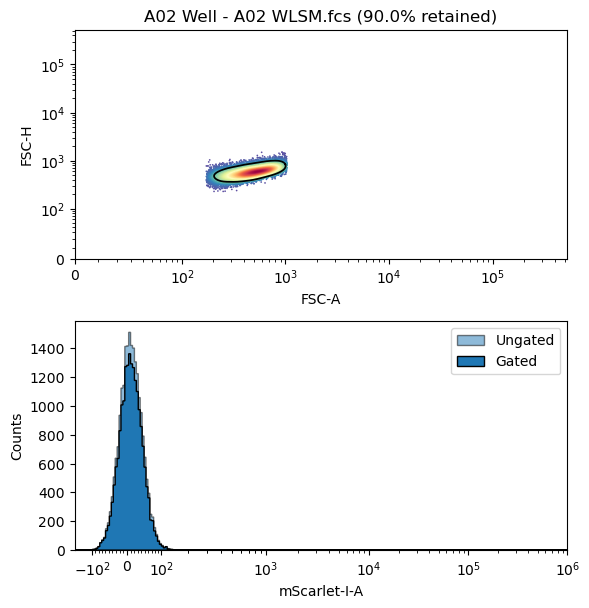

21317 : number of singlet events retained
--------------------------------------------------------------




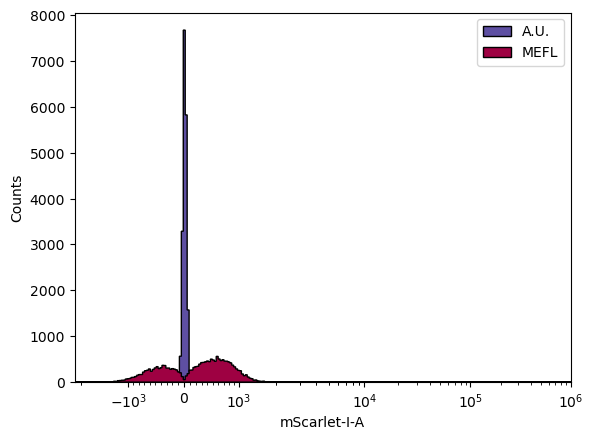

In [13]:
# Make processed data
from scripts_general_fns.g8_process_single_fcs_flowcal import process_single_fcs_flowcal # processing - gating-reduction, MEFLing

processed_single_fcs = \
process_single_fcs_flowcal(single_fcs,
                           to_mef,
                           scatter_channels, fluorescence_channels,
                           make_plots=True)

### Scatter2d plots

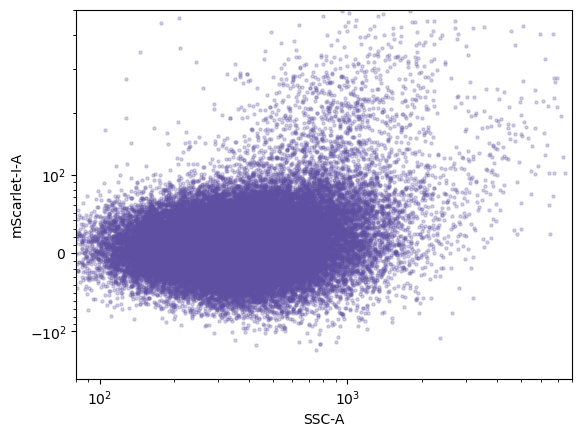

In [14]:
FlowCal.plot.scatter2d(single_fcs, channels = ('SSC-A', fluorescence_channels[0]), xlim = (80, 8e3), ylim = (-200, 500))
# fluorescence_channels[0 or 1] = 'mScarlet-I-A'

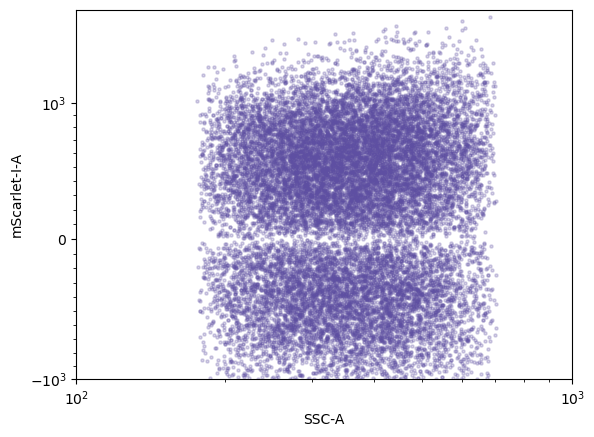

In [15]:
FlowCal.plot.scatter2d(processed_single_fcs, channels = ('SSC-A', fluorescence_channels[0]), xlim=(100, 1000), ylim=(-1e3, 2e3))

### Scatter2d w linear scale
Histogram with linear scale doesn't work.. making a single bin for some reason
let's try density / scatter

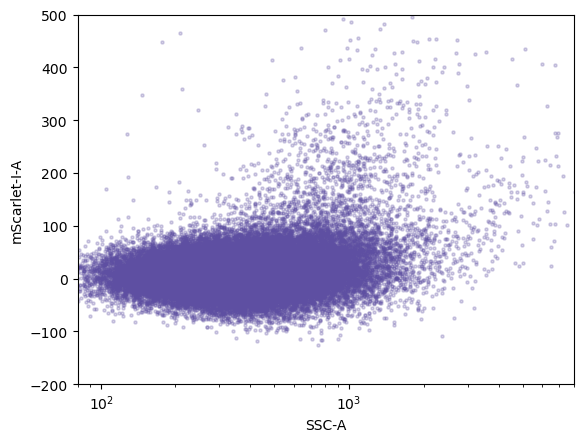

In [16]:
# FlowCal.plot.density2d(single_fcs, channels = ('SSC-A', 'mScarlet-I-A'), mode = 'scatter', xlim = (80, 8e3), ylim = (-200, 500), smooth = False, yscale='linear')
FlowCal.plot.scatter2d(single_fcs, channels = ('SSC-A', 'mScarlet-I-A'), 
                       xlim = (80, 8e3), ylim = (-200, 500), 
                       yscale='linear')

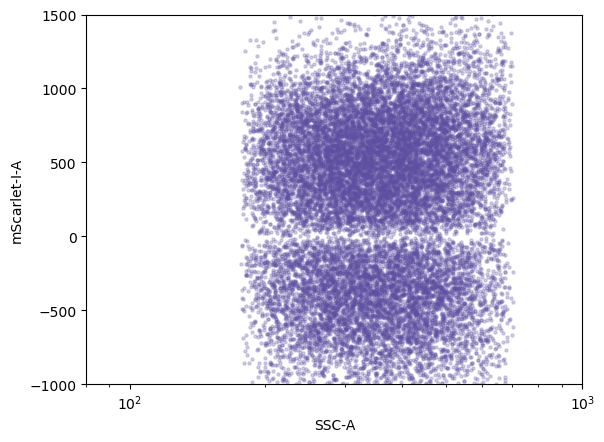

In [17]:
# FlowCal.plot.density2d(single_fcs, channels = ('SSC-A', 'mScarlet-I-A'), mode = 'scatter', xlim = (80, 8e3), ylim = (-200, 500), smooth = False, yscale='linear')
FlowCal.plot.scatter2d(processed_single_fcs, channels = ('SSC-A', 'mScarlet-I-A'), 
                       xlim = (80, 1e3), ylim=(-1e3, 1.5e3),
                       yscale='linear')

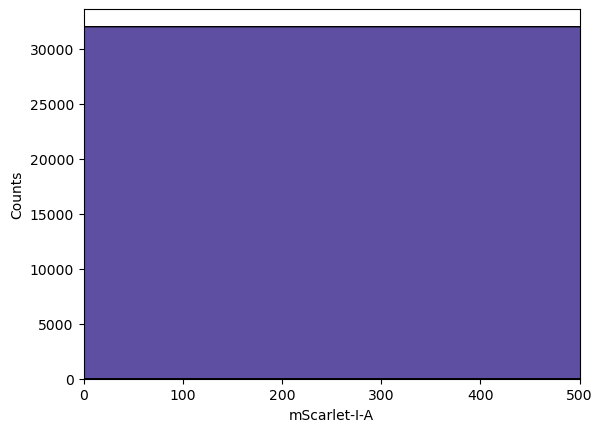

In [18]:
# ignore this
FlowCal.plot.hist1d(single_fcs, channel = fluorescence_channels[0], xscale = 'linear', xlim = (0, 500), bins = 1024)
# FlowCal.plot.hist1d(processed_single_fcs, channel = fluorescence_channels[0], xscale = 'linear', xlim = (-200, 200), bins = 1000)

### hist1d

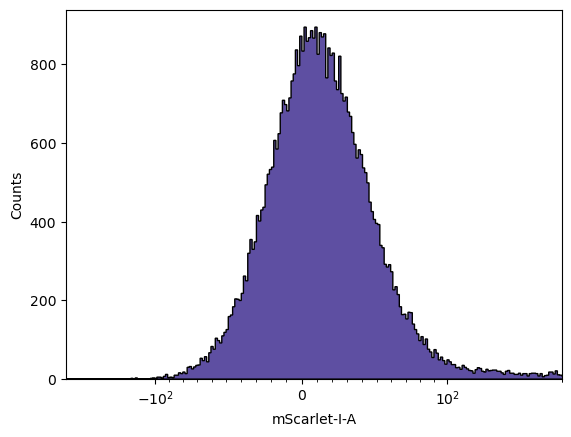

In [19]:
# plot density of single FCS

# see full range and then constrain below for better visual
# FlowCal.plot.hist1d(single_fcs, channel = fluorescence_channels[0])
FlowCal.plot.hist1d(single_fcs, channel = fluorescence_channels[0], xscale = 'logicle', xlim = (-200, 200), bins = 1000)

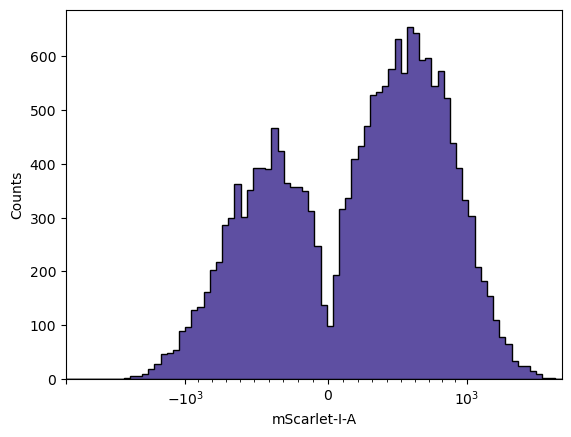

In [20]:
# see full range and then constrain below for better visual
# FlowCal.plot.hist1d(processed_single_fcs, channel = fluorescence_channels[0])

FlowCal.plot.hist1d(processed_single_fcs, channel = fluorescence_channels[0], xlim = (-2e3, 2e3), bins = 200)

### Density2d plots

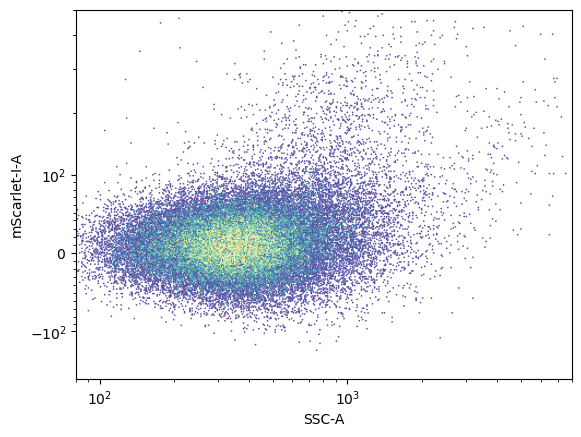

In [21]:
# FlowCal.plot.scatter2d(single_fcs, channels = ('SSC-A', 'FSC-A'))
FlowCal.plot.density2d(single_fcs, channels = ('SSC-A', 'mScarlet-I-A'), mode = 'scatter', xlim = (80, 8e3), ylim = (-200, 500), smooth = False) #, yscale='linear')

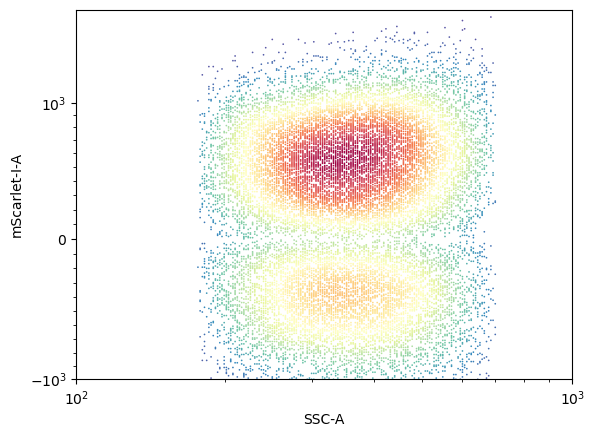

In [22]:
FlowCal.plot.density2d(processed_single_fcs, channels = ('SSC-A', 'mScarlet-I-A'), mode = 'scatter', xlim=(100, 1000), ylim=(-1e3, 2e3)) #, smooth = False)

### Other investigations
Look at hist_bins

In [23]:
single_fcs.hist_bins

<bound method FCSData.hist_bins of FCSData([[1.4543851e+03, 8.2900000e+02, 3.3300000e+02, ...,
          2.1871539e+02, 3.3300000e+02, 0.0000000e+00],
         [1.0655382e+03, 6.2900000e+02, 2.4800000e+02, ...,
          2.0353053e+02, 2.4800000e+02, 1.0000000e+00],
         [3.2503357e+02, 5.9950000e+02, 2.4400000e+02, ...,
          1.7807684e+02, 2.4400000e+02, 1.0000000e+00],
         ...,
         [1.2712141e+03, 8.3850000e+02, 2.1900000e+02, ...,
          1.5462851e+02, 2.1900000e+02, 1.0510100e+05],
         [2.1658000e+02, 4.2100000e+02, 2.0300000e+02, ...,
          1.4990782e+02, 2.0300000e+02, 1.0510300e+05],
         [3.8142603e+02, 6.1350000e+02, 2.2300000e+02, ...,
          1.7900215e+02, 2.2300000e+02, 1.0510300e+05]], dtype=float32)>

In [24]:
processed_single_fcs.hist_bins

<bound method FCSData.hist_bins of FCSData([[3.26978149e+02, 6.50500000e+02, 2.30000000e+02, ...,
          1.23112556e+02, 2.30000000e+02, 2.00000000e+00],
         [8.71772095e+02, 6.66000000e+02, 2.19000000e+02, ...,
          1.72956238e+02, 2.19000000e+02, 4.00000000e+00],
         [4.46553894e+02, 7.30500000e+02, 2.06000000e+02, ...,
          2.33008499e+02, 2.06000000e+02, 4.00000000e+00],
         ...,
         [6.93301941e+02, 7.81000000e+02, 2.16000000e+02, ...,
          1.42337112e+02, 2.16000000e+02, 1.05097000e+05],
         [2.16580002e+02, 4.21000000e+02, 2.03000000e+02, ...,
          1.49907822e+02, 2.03000000e+02, 1.05103000e+05],
         [3.81426025e+02, 6.13500000e+02, 2.23000000e+02, ...,
          1.79002151e+02, 2.23000000e+02, 1.05103000e+05]])>

### Explore MEFL calibration prameters
As John Sexton [suggests](https://github.com/taborlab/FlowCal/issues/359).
Need to run to_mef `FlowCal.mef.get_transform_fxn` with `full_output==True`
 > (It would also be helpful to inspect the calibration model parameters and make sure they make sense--the exponential term should be near 1.0 for modern cytometers, and the linear scaling factor should depend on the detector voltage.

Reading beads from file : A12 Well - A12 WLSM.fcs


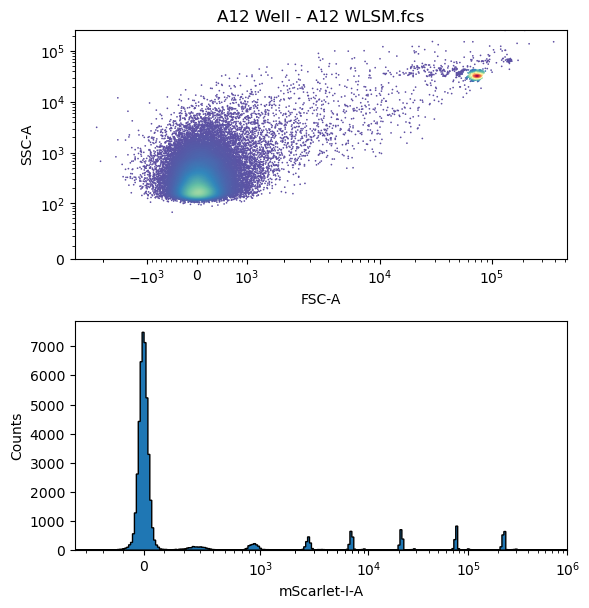

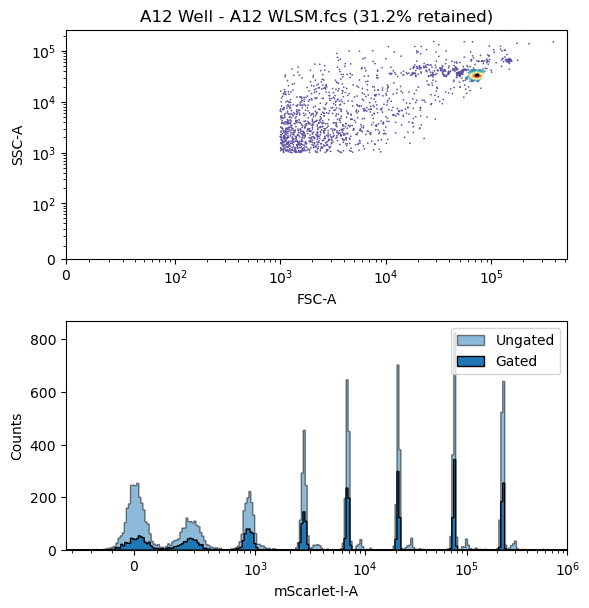

## Getting calibration data from beads

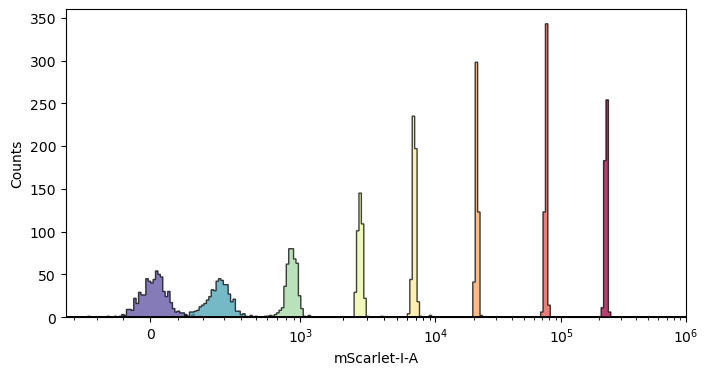

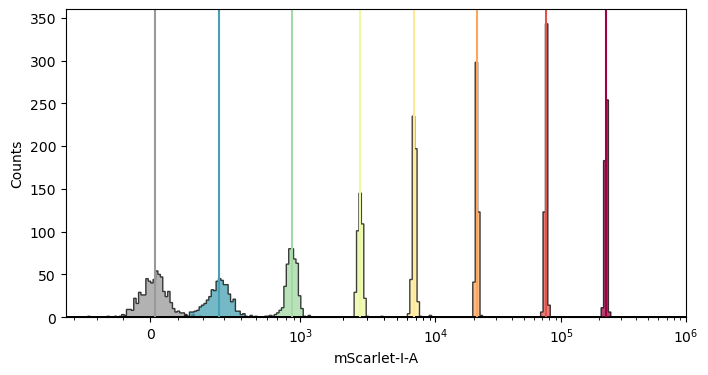

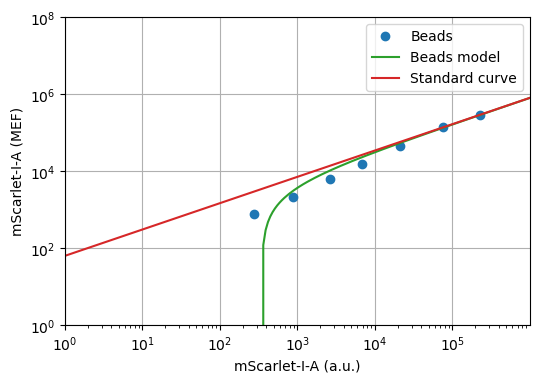

In [25]:
mef_model = process_beads_file(beads_filepath, scatter_channels, fluorescence_channels, give_full_output=True)

In [26]:
mef_model.fitting

{'std_crv': [<function FlowCal.mef.fit_beads_autofluorescence.<locals>.<lambda>(x)>],
 'beads_model': [<function FlowCal.mef.fit_beads_autofluorescence.<locals>.<lambda>(x)>],
 'beads_params': [array([6.84108707e-01, 4.13784424e+00, 3.43021024e+03])],
 'beads_model_str': ['m*log(fl_rfi) + b = log(fl_mef_auto + fl_mef)'],
 'beads_params_names': [['m', 'b', 'fl_mef_auto']]}

Next steps :
- try plotting this model and check if there is a zero avoidance going on
- I assume m is the exponential term John Sexton is referring to, check when posting the reply
- Ask how this can be fixed - new beads etc.?

In [27]:
mef_model.selection

{'rfi': [array([   274.7812,    874.197 ,   2665.2568,   6858.611 ,  21234.66  ,
          75569.44  , 229156.16  ], dtype=float32)],
 'mef': [array([   771.,   2106.,   6262.,  15183.,  45292., 136258., 291042.])]}

# Processing .fcs wrapper : gating to MEFL
(Optional)

---> density gate


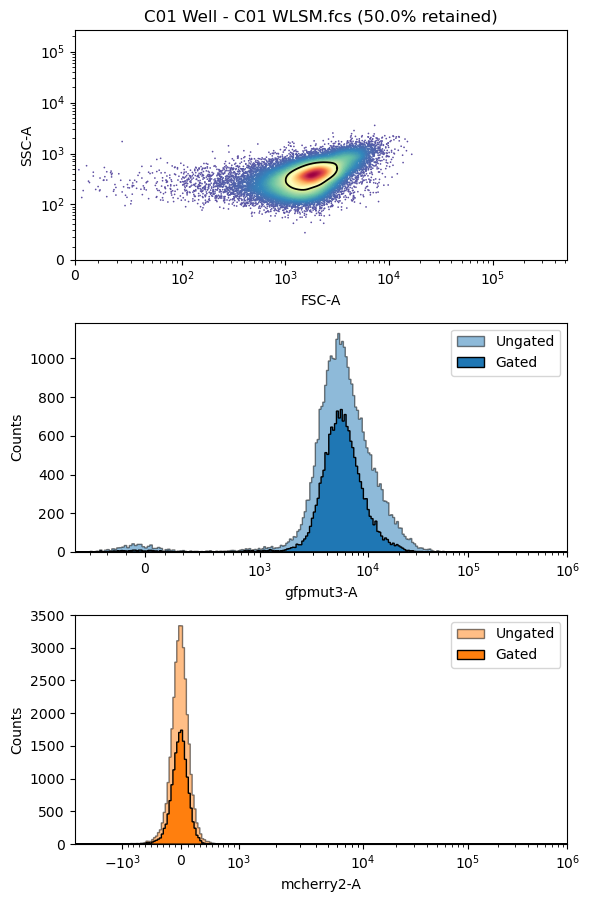

---> singlet gate


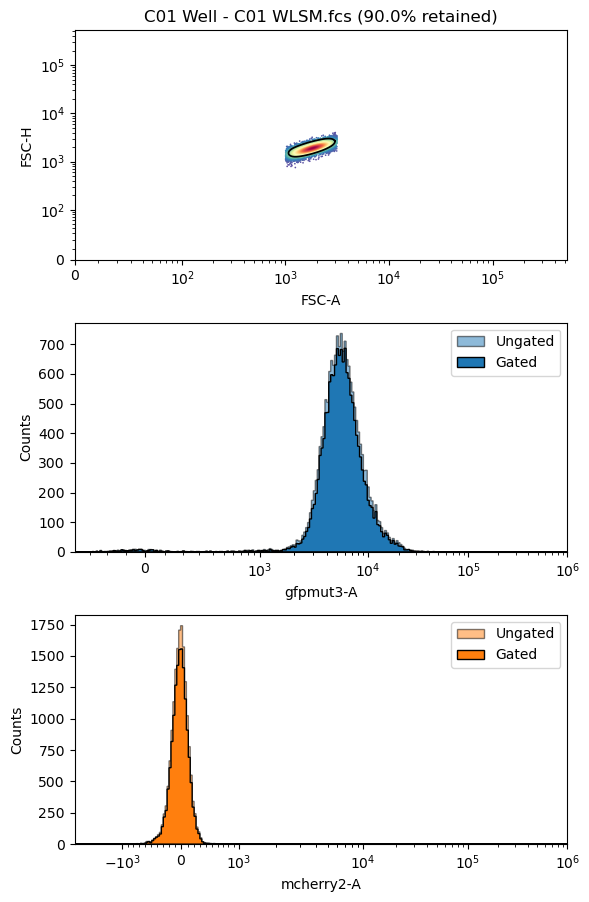

16820 : number of singlet events retained
--------------------------------------------------------------




In [11]:
# Show plots of a dataset, adjust gating fraction manually. Use next code block for quick change of well too!
gated_single_fcs = \
gate_and_reduce_dataset(single_fcs,\
           scatter_channels, fluorescence_channels, density_gating_fraction=.5,
           make_plots = True) ;

---> density gate


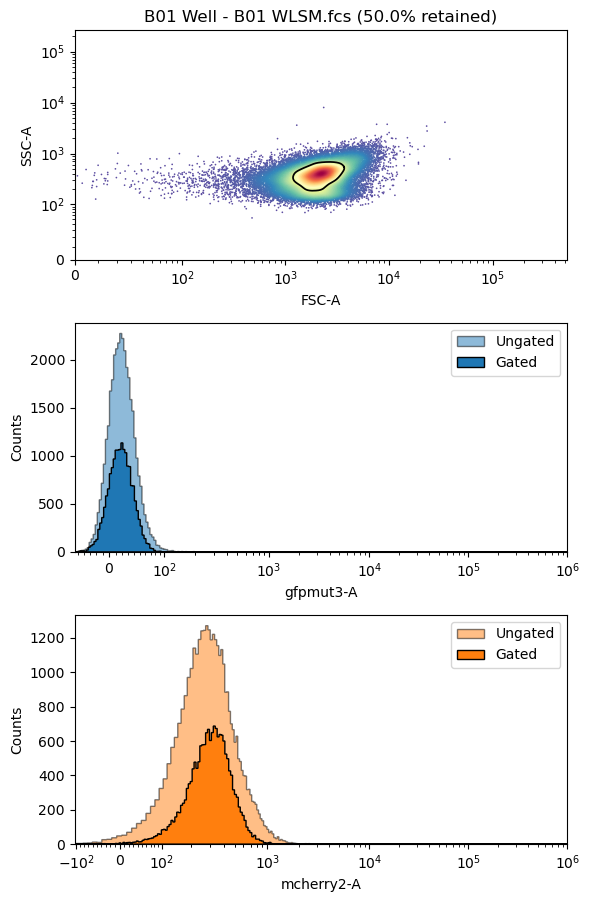

---> singlet gate


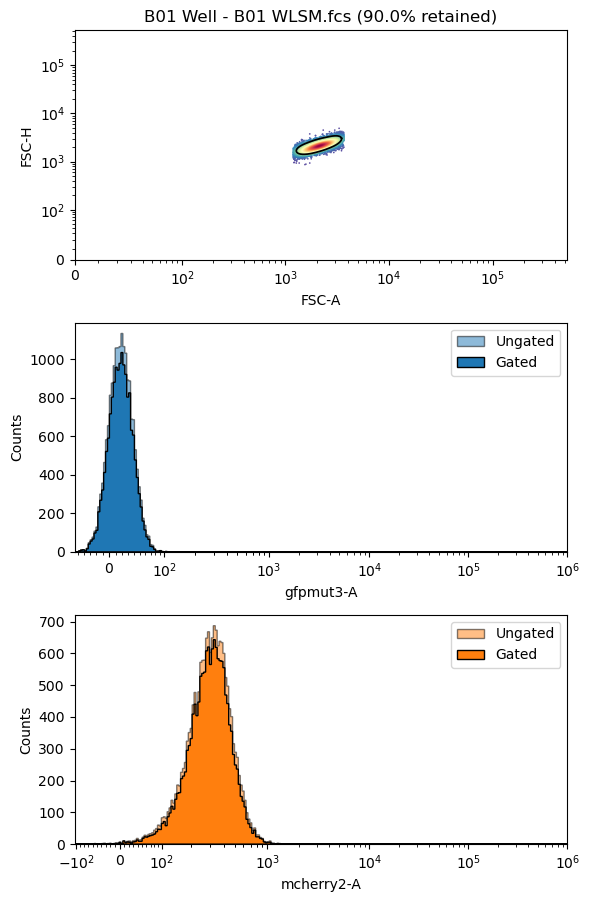

17453 : number of singlet events retained
--------------------------------------------------------------




In [12]:
# Show plots of a dataset, adjust gating fraction manually for any well.
from scripts_general_fns.g3_python_utils_facs import select_well_and_show_gating
select_well_and_show_gating('B01', 0.5, fcspaths, fcslist)

# Testing other features

In [128]:
# get summary stats and test pandas on the base data / processed data
summary_stats_list = (['mean', 'median', 'mode'],
                      [FlowCal.stats.mean, FlowCal.stats.median, FlowCal.stats.mode])

# Generate a combined dataframe for mean, median and mode respectively
summary_stats_processed = map(lambda x, y: [y(single_fcs, 
                         channels = fluorescence_channels)\
                   for single_fcs in processed_fcs_data] |\
    p(pd.DataFrame, 
      columns = [x + '_' + chnl for chnl in fluorescence_channels],
     index = fcslist_subset), summary_stats_list[0], summary_stats_list[1]) | p(pd.concat, px, axis = 1)

ValueError: Length of values (17) does not match length of index (19)

In [12]:
# adhoc run with functions
from scripts_general_fns.g8_process_single_fcs_flowcal import process_single_fcs_flowcal
calibrated_single_fcs = process_single_fcs_flowcal(single_fcs, to_mef, scatter_channels, fluorescence_channels)

---> Raw data


In [11]:
fcs_data = [FlowCal.io.FCSData(fcs_file) for fcs_file in fcspaths]

In [12]:
final_counts = np.array([single_fcs.__len__() for single_fcs in fcs_data])

In [20]:
tst = pd.DataFrame({ 'final_events' : [single_fcs.__len__() for single_fcs in fcs_data]})

# Troubleshooting basic python

In [246]:
';'.join(['ants', 'gpds'])

'ants;gpds'

In [109]:
# interesting example to get both index and the interator
indx, empties = zip(*[(i, a) for (i,a) in enumerate(processed_fcs_data) if a.__len__() == 0])

In [138]:
a = range(3)
f'list is : {*a,}'

'list is : (0, 1, 2)'

# Testing utilities
- on single fcs files etc.

In [62]:
# process all .fcs files : (skips MEFLing if beads are absent)
from scripts_general_fns.g8_process_single_fcs_flowcal import process_single_fcs_flowcal # processing - gating-reduction, MEFLing

processed_fcs_data = [process_single_fcs_flowcal\
                       (single_fcs,
                        to_mef,
                        scatter_channels, fluorescence_channels,
                        make_plots=None)\
                  for single_fcs in fcs_data_subset]

In [126]:
# Remove .fcs data where no events are left after the filtering process
empty_fcs_names = None # default

empty_fcs_indices = [i for (i,single_fcs) in enumerate(processed_fcs_data) if single_fcs.__len__() == 0] # get the index of the empties
empty_fcs_names = [x for i,x in enumerate(fcslist) if i in empty_fcs_indices]

fcslist_subset = [x for i,x in enumerate(fcslist_subset) if i not in empty_fcs_indices] 
fcspaths_subset = [x for i,x in enumerate(fcspaths_subset) if i not in empty_fcs_indices] 
processed_fcs_data = [x for i,x in enumerate(processed_fcs_data) if i not in empty_fcs_indices] 

In [127]:
fcslist_subset.__len__()

19

In [124]:
[fl.__len__() for fl in processed_fcs_data]

[13733,
 13829,
 14466,
 14782,
 14406,
 13812,
 13647,
 13942,
 15272,
 14264,
 704,
 17210,
 18316,
 16167,
 15284,
 15468,
 14572,
 15141,
 14507]

---> density gate


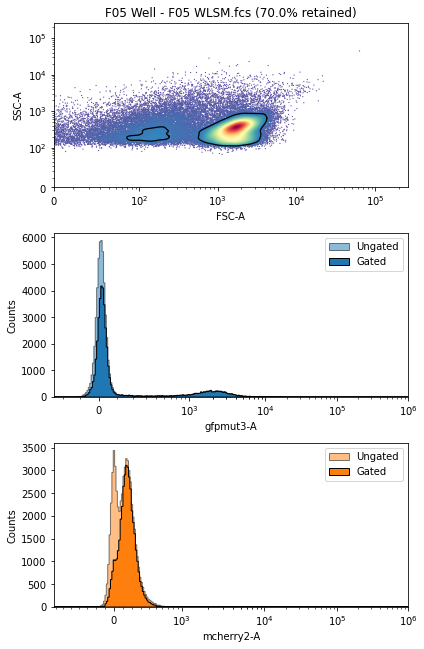

---> singlet gate


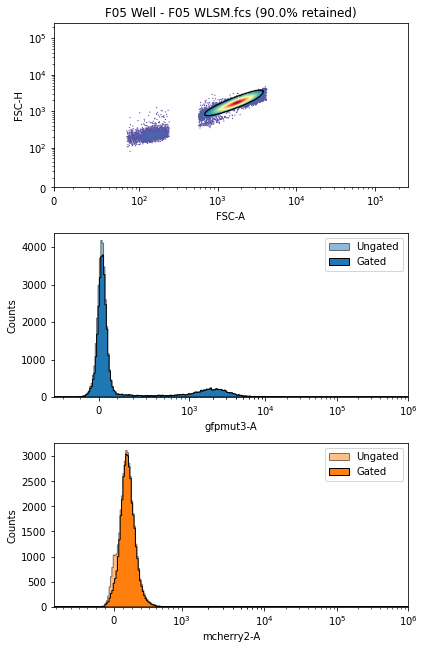

--------------------------------------------------------------




In [21]:
# Gate and plot a single file - testing the density_gating_fraction
singlefcs_singlets90 = gate_and_reduce_dataset(fcs_data_subset[1], scatter_channels, fluorescence_channels, density_gating_fraction = 0.7, make_plots = True)

# Run a customized analysis workflow : for efficiency/speed
- Custom for S050 multi-plate dataset
- The beads file is processed only once and re-used for all the plates
- Trying to get a vectorized workflow/loop going

In [10]:
# More imports
import re # for regular expression : string matching
from IPython.display import display, Markdown # for generating markdown messages
from sspipe import p, px # pipes usage: x | p(fn) | p(fn2, arg1, arg2 = px)

# import local packages
import scripts_general_fns.g3_python_utils_facs as myutils # general utlilties
from scripts_general_fns.g4_file_inputs import get_fcs_files # reading in .fcs files
from scripts_general_fns.g15_beads_functions import process_beads_file # get and process beads data
from scripts_general_fns.g8_process_single_fcs_flowcal import process_single_fcs_flowcal # processing - gating-reduction, MEFLing
from scripts_general_fns.g9_write_fcs_wrapper import write_FCSdata_to_fcs # .fcs output

In [11]:
# test workflow on d-1 : updating g10_user_config now

# import config : directory names - refresh the config
from scripts_general_fns.g10_user_config import fcs_root_folder, fcs_experiment_folder
print(fcs_experiment_folder) # check that corect file is loaded

In [ ]:
# loop for every experiment folder 
for fcs_experiment_folder in ['S050/S050_d' + str(x) for x in (np.array(range(7)) + 2)]:

    # get .fcs file list and load data
    fcspaths, fcslist = get_fcs_files(fcs_root_folder + '/' + fcs_experiment_folder + '/')
    # output file paths
    # trim the directory to remove excessive subsidectories (from Sony instruments)
    outfcspaths = ['processed_data/' + fcs_experiment_folder + '/' + os.path.basename(singlefcspath) \
                   for singlefcspath in fcspaths]

In [51]:
    fcs_data = [FlowCal.io.FCSData(fcs_file) for fcs_file in fcspaths]

    # convert data into MEFLs for all .fcs files
    calibrated_fcs_data = [process_single_fcs_flowcal\
                           (single_fcs,
                            to_mef,
                            scatter_channels, fluorescence_channels)\
                      for single_fcs in fcs_data]

    # get summary statistics
    summary_stats_list = (['mean', 'median', 'mode'], # use these labels and functions below
                      [FlowCal.stats.mean, FlowCal.stats.median, FlowCal.stats.mode])

    # Generate a combined pandas DataFrame for mean, median and mode respectively
    summary_stats = map(lambda x, y: [y(single_fcs, channels = fluorescence_channels) for single_fcs in calibrated_fcs_data] |\
        p(pd.DataFrame, 
          columns = [x + '_' + chnl for chnl in fluorescence_channels], # name the columns: "summarystat_fluorophore"
          index = fcslist), # rownames as the .fcs file names
        summary_stats_list[0], # x for the map, y is below
        summary_stats_list[1]) | p(pd.concat, px, axis = 1)

    # Save summary statistic to csv file
    summary_stats.to_csv('FACS_analysis/tabular_outputs/' + fcs_experiment_folder + '-summary.csv',
                        index_label='well')

    # Save calibrated fcs data to file
    [write_FCSdata_to_fcs(filepath, fcs_data) \
     for filepath, fcs_data in zip(outfcspaths, calibrated_fcs_data)]

    # remove .fcs holding lists to save memory
    del fcs_data
    del calibrated_fcs_data


 file saved :  A01 Well - A01 WLSM.fcs

 file saved :  A02 Well - A02 WLSM.fcs

 file saved :  A03 Well - A03 WLSM.fcs

 file saved :  A04 Well - A04 WLSM.fcs

 file saved :  A05 Well - A05 WLSM.fcs

 file saved :  A06 Well - A06 WLSM.fcs

 file saved :  A07 Well - A07 WLSM.fcs

 file saved :  A08 Well - A08 WLSM.fcs

 file saved :  A09 Well - A09 WLSM.fcs

 file saved :  B01 Well - B01 WLSM.fcs

 file saved :  B02 Well - B02 WLSM.fcs

 file saved :  B03 Well - B03 WLSM.fcs

 file saved :  B04 Well - B04 WLSM.fcs

 file saved :  B05 Well - B05 WLSM.fcs

 file saved :  B06 Well - B06 WLSM.fcs

 file saved :  B07 Well - B07 WLSM.fcs

 file saved :  B08 Well - B08 WLSM.fcs

 file saved :  B09 Well - B09 WLSM.fcs

 file saved :  C01 Well - C01 WLSM.fcs

 file saved :  C02 Well - C02 WLSM.fcs

 file saved :  C03 Well - C03 WLSM.fcs

 file saved :  C04 Well - C04 WLSM.fcs

 file saved :  C05 Well - C05 WLSM.fcs

 file saved :  C06 Well - C06 WLSM.fcs

 file saved :  C07 Well - C07 WLSM.fcs
